# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [48]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import RemoveMessage
from langchain_core.messages import trim_messages

In [2]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
messages = [AIMessage(content="So you are researching on Penguins")]
messages.append(HumanMessage(content="I am looking for penguins in Antartica"))

for msg in messages:
    msg.pretty_print()

================================== Ai Message ==================================

So you are researching on Penguins
================================ Human Message =================================

I am looking for penguins in Antartica


In [4]:
llm = ChatOpenAI(model="gpt-4o")
op = llm.invoke(messages)

In [5]:
op.pretty_print()

================================== Ai Message ==================================

If you're interested in observing penguins in Antarctica, you're in for a remarkable experience! Antarctica is home to several species of penguins, each with unique behaviors and habitats. Here are some of the penguin species you can find there:

1. **Emperor Penguins**: The largest of all penguin species, emperor penguins are famous for their incredible breeding cycle during the harsh Antarctic winter. They are primarily found on the sea ice surrounding Antarctica.

2. **Adélie Penguins**: Known for their classic tuxedo appearance, Adélie penguins are abundant along the Antarctic coast. They breed on rocky, ice-free areas.

3. **Gentoo Penguins**: Recognizable by the white stripe across their heads, gentoo penguins are found on many sub-Antarctic islands as well as the Antarctic Peninsula.

4. **Chinstrap Penguins**: These penguins, named for the distinctive black band under their heads, also inhabit the

We can run our chat model in a simple graph with `MessagesState` The same thing

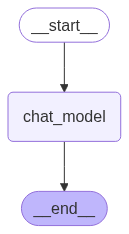

In [6]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

So you are researching on Penguins
================================ Human Message =================================

I am looking for penguins in Antartica
================================== Ai Message ==================================

If you're searching for penguins in Antarctica, you're in for a fascinating experience. Antarctica is home to several species of penguins, each with unique characteristics and habitats. Here are some of the most notable penguin species you can find there:

1. **Emperor Penguin**: The largest of all penguin species, emperor penguins are known for their majestic stature and intriguing breeding habits. They breed during the Antarctic winter, with males incubating the eggs during harsh conditions.

2. **Adélie Penguin**: Recognizable by their classic black-and-white coloring and distinctively white eye ring, Adélie penguins are one of the most widespread penguin species in An

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

In [41]:
# define the nodes
def remove_message(state: MessagesState):
    print("remove_message")
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messsages": delete_messages}


def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

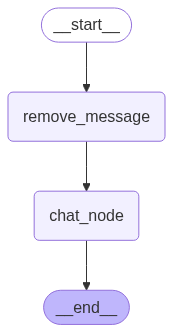

In [42]:
# lets build the graph
builder = StateGraph(MessagesState)
# add nodes
builder.add_node("remove_message", remove_message)
builder.add_node("chat_node", chat_model_node)
# add edges
builder.add_edge(START, "remove_message")
builder.add_edge("remove_message", "chat_node")
builder.add_edge("chat_node", END)
# compile
graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

remove_message
================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating groups of ocean mammals you might want to learn about:

1. **Dolphins and Porpoises**: These are closely related to whales and belong to the cetacean family. Dolphins are generally larger and have more elongated snouts compared to porpoises. They're known for their intelligence and complex social behaviors.

2. **Seals, Sea Lions, and Walruses (Pinni

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

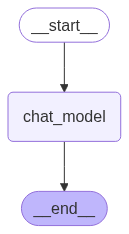

In [44]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
messages.append(output["messages"][-1])
messages.append(HumanMessage(f"What is my name again??", name="Lance"))
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating groups of ocean mammals you might want to learn about:

1. **Dolphins and Porpoises**: These are closely related to whales and belong to the cetacean family. Dolphins are generally larger and have more elongated snouts compared to porpoises. They're known for their intelligence and complex social behaviors.

2. **Seals, Sea Lions, and Walruses (Pinnipeds)**:
   - *

In [46]:
# Invoke, using message filtering
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating groups of ocean mammals you might want to learn about:

1. **Dolphins and Porpoises**: These are closely related to whales and belong to the cetacean family. Dolphins are generally larger and have more elongated snouts compared to porpoises. They're known for their intelligence and complex social behaviors.

2. **Seals, Sea Lions, and Walruses (Pinnipeds)**:
   - *

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

In [50]:
# define the nodes
def trim_node(state: MessagesState):
    trimmed_messages = trim_messages(
        messages=state["messages"], max_tokens=100, strategy="last", token_counter=llm, allow_partial=True
    )
    return {"messages": trimmed_messages}


def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

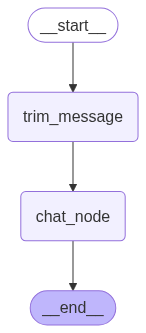

In [51]:
# lets build the graph
builder = StateGraph(MessagesState)
# add nodes
builder.add_node("trim_message", trim_node)
builder.add_node("chat_node", chat_model_node)
# add edges
builder.add_edge(START, "trim_message")
builder.add_edge("trim_message", "chat_node")
builder.add_edge("chat_node", END)
# compile
graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [53]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [54]:
for msg in messages_out_trim['messages']:
    msg.pretty_print()


================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating groups of ocean mammals you might want to learn about:

1. **Dolphins and Porpoises**: These are closely related to whales and belong to the cetacean family. Dolphins are generally larger and have more elongated snouts compared to porpoises. They're known for their intelligence and complex social behaviors.

2. **Seals, Sea Lions, and Walruses (Pinnipeds)**:
   - *

################################## END #######################